# Catalyst segmentation tutorial

Authors: [Roman Tezikov](https://github.com/TezRomacH), [Dmitry Bleklov](https://github.com/Bekovmi), [Sergey Kolesnikov](https://github.com/Scitator)

[![Catalyst logo](https://raw.githubusercontent.com/catalyst-team/catalyst-pics/master/pics/catalyst_logo.png)](https://github.com/catalyst-team/catalyst)

### Colab setup

First of all, do not forget to change the runtime type to GPU. <br/>
To do so click `Runtime` -> `Change runtime type` -> Select `"Python 3"` and `"GPU"` -> click `Save`. <br/>
After that you can click `Runtime` -> `Run all` and watch the tutorial.



## Requirements

Download and install the latest versions of catalyst and other libraries required for this tutorial.

In [1]:
# this variable will be used in `runner.train` and by default we disable FP16 mode
is_fp16_used = False

In [2]:
# Catalyst
!pip install catalyst==20.12

# for augmentations
!pip install albumentations==0.4.3

# for pretrained segmentation models for PyTorch
!pip install segmentation-models-pytorch==0.1.0

# for TTA
!pip install ttach==0.0.2

# for tensorboard
!pip install tensorflow

# if Your machine support Apex FP16, uncomment this 3 lines below
# !git clone https://github.com/NVIDIA/apex
# !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex
# is_fp16_used = True

## Setting up GPUs

In [3]:
from typing import Callable, List, Tuple

import os
import torch
import catalyst
from catalyst import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

torch: 1.10.0+cu111, catalyst: 20.12


## Dataset

As a dataset we will take Carvana - binary segmentation for the "car" class.

> If you are on MacOS and you don’t have `wget`, you can install it with: `brew install wget`.

After Catalyst installation, `download-gdrive` function become available to download objects from Google Drive.
We use it to download datasets.

usage: `download-gdrive {FILE_ID} {FILENAME}`

In [4]:
%%bash

download-gdrive 1iYaNijLmzsrMlAdMoUEhhJuo-5bkeAuj segmentation_data.zip
extract-archive segmentation_data.zip &>/dev/null

--2022-04-15 01:24:31--  https://docs.google.com/uc?export=download&confirm=t&id=1iYaNijLmzsrMlAdMoUEhhJuo-5bkeAuj
Resolving docs.google.com (docs.google.com)... 142.250.159.113, 142.250.159.139, 142.250.159.101, ...
Connecting to docs.google.com (docs.google.com)|142.250.159.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h4vppesofkj0v9o29ablo4km20q18f50/1649985825000/01187487326786428538/*/1iYaNijLmzsrMlAdMoUEhhJuo-5bkeAuj?e=download [following]
--2022-04-15 01:24:31--  https://doc-10-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h4vppesofkj0v9o29ablo4km20q18f50/1649985825000/01187487326786428538/*/1iYaNijLmzsrMlAdMoUEhhJuo-5bkeAuj?e=download
Resolving doc-10-60-docs.googleusercontent.com (doc-10-60-docs.googleusercontent.com)... 108.177.111.132, 2607:f8b0:4001:c07::84
Connecting to doc-10-60-docs.googleusercontent.com (doc-

In [5]:
from pathlib import Path

ROOT = Path("segmentation_data/")

train_image_path = ROOT / "train"
train_mask_path = ROOT / "train_masks"
test_image_path = ROOT / "test"

Collect images and masks into variables.

In [6]:
ALL_IMAGES = sorted(train_image_path.glob("*.jpg"))
len(ALL_IMAGES)

5088

In [7]:
ALL_MASKS = sorted(train_mask_path.glob("*.gif"))
len(ALL_MASKS)

5088

In [8]:
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread as gif_imread
from catalyst import utils


def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = utils.imread(image_path)
    mask = gif_imread(masks[index])

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

You can restart the cell below to see more examples.

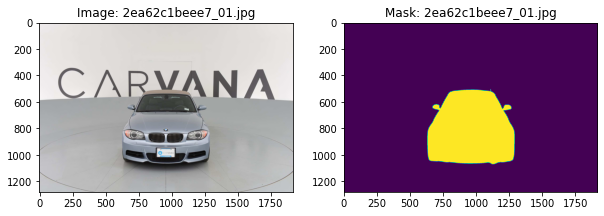

In [9]:
show_random(ALL_IMAGES, ALL_MASKS)

The dataset below reads images and masks and optionally applies augmentation to them.

In [10]:
from typing import List

from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(
        self,
        images: List[Path],
        masks: List[Path] = None,
        transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = utils.imread(image_path)
        
        result = {"image": image}
        
        if self.masks is not None:
            mask = gif_imread(self.masks[idx])
            result["mask"] = mask
        
        if self.transforms is not None:
            result = self.transforms(**result)
        
        result["filename"] = image_path.name

        return result

-------

### Augmentations

[![Albumentation logo](https://albumentations.readthedocs.io/en/latest/_static/logo.png)](https://github.com/albu/albumentations)

The [albumentation](https://github.com/albu/albumentations) library works with images and masks at the same time, which is what we need.

In [11]:
import albumentations as albu
from albumentations.pytorch import ToTensor


def pre_transforms(image_size=224):
    return [albu.Resize(image_size, image_size, p=1)]


def hard_transforms():
    result = [
      albu.RandomRotate90(),
      albu.Cutout(),
      albu.RandomBrightnessContrast(
          brightness_limit=0.2, contrast_limit=0.2, p=0.3
      ),
      albu.GridDistortion(p=0.3),
      albu.HueSaturationValue(p=0.3)
    ]

    return result
  

def resize_transforms(image_size=224):
    BORDER_CONSTANT = 0
    pre_size = int(image_size * 1.5)

    random_crop = albu.Compose([
      albu.SmallestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    rescale = albu.Compose([albu.Resize(image_size, image_size, p=1)])

    random_crop_big = albu.Compose([
      albu.LongestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    # Converts the image to a square of size image_size x image_size
    result = [
      albu.OneOf([
          random_crop,
          rescale,
          random_crop_big
      ], p=1)
    ]

    return result
  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]
  
def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [12]:
train_transforms = compose([
    resize_transforms(), 
    hard_transforms(), 
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([resize_transforms(), hard_transforms()])

Let's look at the augmented results. <br/>
You can restart the cell below to see more examples of augmentations.

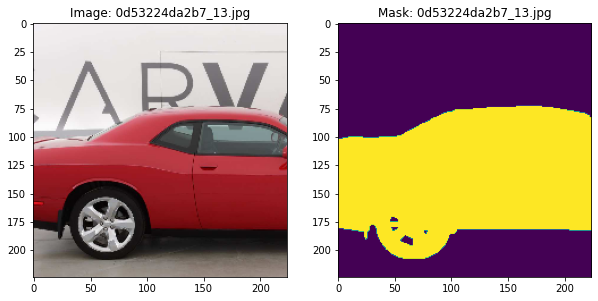

In [13]:
show_random(ALL_IMAGES, ALL_MASKS, transforms=show_transforms)

-------

## Loaders

In [23]:
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int,
    valid_size: float = 0.2,
    batch_size: int = 32,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Catalyst uses normal torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And excpect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [24]:
if is_fp16_used:
    batch_size = 64
else:
    batch_size = 32

print(f"batch_size: {batch_size}")

loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=SEED,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size
)

batch_size: 32


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



-------

## Experiment
### Model

Catalyst has [several segmentation models](https://github.com/catalyst-team/catalyst/blob/master/catalyst/contrib/models/segmentation/__init__.py#L16) (Unet, Linknet, FPN, PSPnet and their versions with pretrain from Resnet).

> You can read more about them in [our blog post](https://github.com/catalyst-team/catalyst-info#catalyst-info-1-segmentation-models).

But for now let's take the model from [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) (SMP for short). The same segmentation architectures have been implemented in this repository, but there are many more pre-trained encoders.

[![Segmentation Models logo](https://raw.githubusercontent.com/qubvel/segmentation_models.pytorch/master/pics/logo-small-w300.png)](https://github.com/qubvel/segmentation_models.pytorch)

In [14]:
import segmentation_models_pytorch as smp

# We will use Feature Pyramid Network with pre-trained ResNeXt50 backbone
model = smp.FPN(encoder_name="resnext50_32x4d", classes=1)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

### Model training

We will optimize loss as the sum of IoU, Dice and BCE, specifically this function: $IoU + Dice + 0.8*BCE$.


In [15]:
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}

In [16]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

learning_rate = 0.001
encoder_learning_rate = 0.0005

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=2)

In [17]:
from catalyst.dl import SupervisedRunner

num_epochs = 3
logdir = "./logs/segmentation"

device = utils.get_device()
print(f"device: {device}")

if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")


# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cuda
FP16 params: None


### Monitoring in tensorboard

If you do not have a Tensorboard opened after you have run the cell below, try running the cell again.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {logdir}

### Running train-loop

In [25]:
from catalyst.dl import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback
from catalyst.contrib.callbacks import DrawMasksCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
    # visualization
    DrawMasksCallback(output_key='logits',
                      input_image_key='image',
                      input_mask_key='mask',
                      summary_step=50
    )
]

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    # prints train logs
    verbose=True,
)

1/3 * Epoch (train):   0% 0/127 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



1/3 * Epoch (train):   1% 1/127 [00:19<40:17, 19.19s/it, dice=0.428, iou=0.272, loss=2.271, loss_bce=1.214, loss_dice=0.572, loss_iou=0.728]

/usr/local/lib/python3.7/dist-packages/catalyst/contrib/nn/optimizers/radam.py:85: UserWarning:

This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)



1/3 * Epoch (train): 100% 127/127 [04:23<00:00,  2.07s/it, dice=0.934, iou=0.877, loss=0.254, loss_bce=0.082, loss_dice=0.066, loss_iou=0.123]
1/3 * Epoch (valid): 100% 31/31 [00:55<00:00,  1.79s/it, dice=0.925, iou=0.860, loss=0.265, loss_bce=0.063, loss_dice=0.075, loss_iou=0.140]
[2022-04-15 01:31:59,898] 
1/3 * Epoch 1 (_base): lr=0.0005 | momentum=0.9000
1/3 * Epoch 1 (train): dice=0.8405 | iou=0.7432 | loss=0.6157 | loss_bce=0.2492 | loss_dice=0.1595 | loss_iou=0.2568
1/3 * Epoch 1 (valid): dice=0.9223 | iou=0.8558 | loss=0.2761 | loss_bce=0.0678 | loss_dice=0.0777 | loss_iou=0.1442


INFO:metrics_logger:
1/3 * Epoch 1 (_base): lr=0.0005 | momentum=0.9000
1/3 * Epoch 1 (train): dice=0.8405 | iou=0.7432 | loss=0.6157 | loss_bce=0.2492 | loss_dice=0.1595 | loss_iou=0.2568
1/3 * Epoch 1 (valid): dice=0.9223 | iou=0.8558 | loss=0.2761 | loss_bce=0.0678 | loss_dice=0.0777 | loss_iou=0.1442


2/3 * Epoch (train): 100% 127/127 [04:20<00:00,  2.05s/it, dice=0.962, iou=0.926, loss=0.154, loss_bce=0.052, loss_dice=0.038, loss_iou=0.074]
2/3 * Epoch (valid): 100% 31/31 [00:55<00:00,  1.78s/it, dice=0.965, iou=0.933, loss=0.125, loss_bce=0.029, loss_dice=0.035, loss_iou=0.067]
[2022-04-15 01:37:21,161] 
2/3 * Epoch 2 (_base): lr=0.0005 | momentum=0.9000
2/3 * Epoch 2 (train): dice=0.9501 | iou=0.9051 | loss=0.2030 | loss_bce=0.0727 | loss_dice=0.0499 | loss_iou=0.0949
2/3 * Epoch 2 (valid): dice=0.9636 | iou=0.9297 | loss=0.1320 | loss_bce=0.0317 | loss_dice=0.0364 | loss_iou=0.0703


INFO:metrics_logger:
2/3 * Epoch 2 (_base): lr=0.0005 | momentum=0.9000
2/3 * Epoch 2 (train): dice=0.9501 | iou=0.9051 | loss=0.2030 | loss_bce=0.0727 | loss_dice=0.0499 | loss_iou=0.0949
2/3 * Epoch 2 (valid): dice=0.9636 | iou=0.9297 | loss=0.1320 | loss_bce=0.0317 | loss_dice=0.0364 | loss_iou=0.0703


3/3 * Epoch (train): 100% 127/127 [04:18<00:00,  2.04s/it, dice=0.977, iou=0.955, loss=0.094, loss_bce=0.033, loss_dice=0.023, loss_iou=0.045]
3/3 * Epoch (valid): 100% 31/31 [00:55<00:00,  1.78s/it, dice=0.975, iou=0.951, loss=0.092, loss_bce=0.022, loss_dice=0.025, loss_iou=0.049]
[2022-04-15 01:42:41,166] 
3/3 * Epoch 3 (_base): lr=0.0005 | momentum=0.9000
3/3 * Epoch 3 (train): dice=0.9696 | iou=0.9411 | loss=0.1252 | loss_bce=0.0448 | loss_dice=0.0304 | loss_iou=0.0589
3/3 * Epoch 3 (valid): dice=0.9729 | iou=0.9471 | loss=0.0998 | loss_bce=0.0248 | loss_dice=0.0271 | loss_iou=0.0529


INFO:metrics_logger:
3/3 * Epoch 3 (_base): lr=0.0005 | momentum=0.9000
3/3 * Epoch 3 (train): dice=0.9696 | iou=0.9411 | loss=0.1252 | loss_bce=0.0448 | loss_dice=0.0304 | loss_iou=0.0589
3/3 * Epoch 3 (valid): dice=0.9729 | iou=0.9471 | loss=0.0998 | loss_bce=0.0248 | loss_dice=0.0271 | loss_iou=0.0529


Top best models:
logs/segmentation/checkpoints/train.3.pth	0.9471


## Model inference

Let's look at the model's predictions.


In [27]:
TEST_IMAGES = sorted(test_image_path.glob("*.jpg"))

# create test dataset
test_dataset = SegmentationDataset(
    TEST_IMAGES, 
    transforms=valid_transforms
)

num_workers: int = 4

infer_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

# this get predictions for the whole loader
predictions = np.vstack(list(map(
    lambda x: x["logits"].cpu().numpy(), 
    runner.predict_loader(loader=infer_loader, resume=f"{logdir}/checkpoints/best.pth")
)))

print(type(predictions))
print(predictions.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



<class 'numpy.ndarray'>
(721, 1, 224, 224)


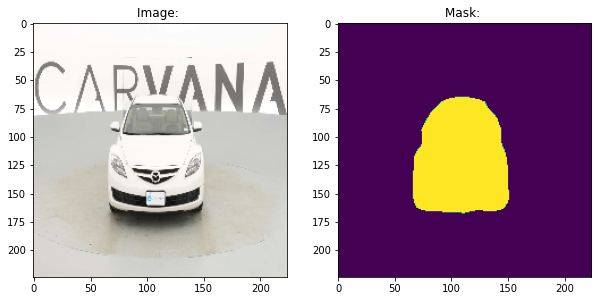

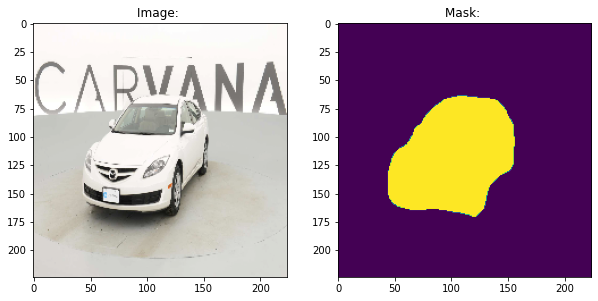

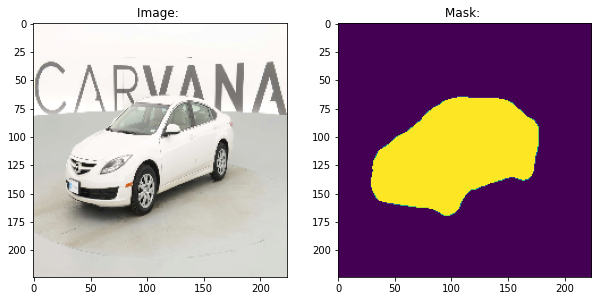

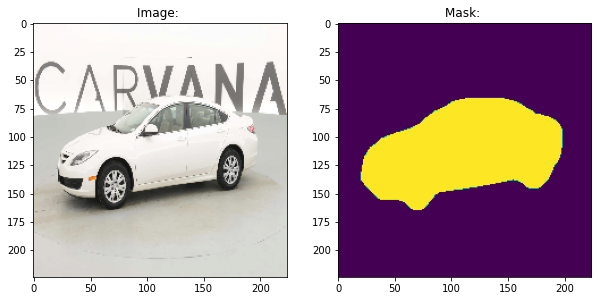

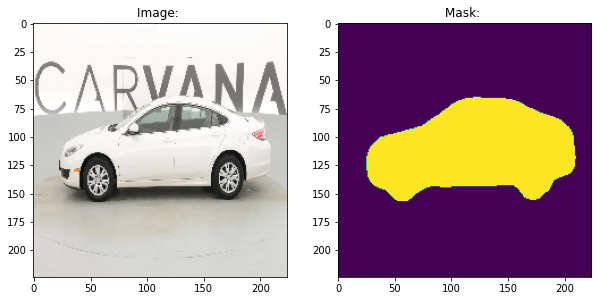

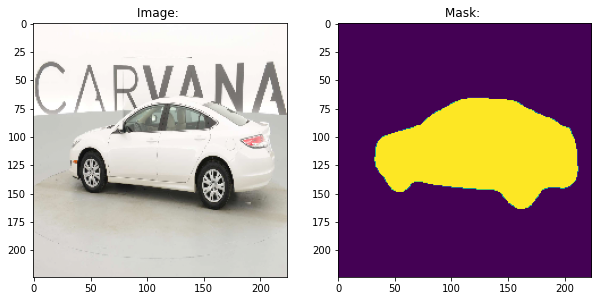

In [28]:
threshold = 0.5
max_count = 5

for i, (features, logits) in enumerate(zip(test_dataset, predictions)):
    image = utils.tensor_to_ndimage(features["image"])

    mask_ = torch.from_numpy(logits[0]).sigmoid()
    mask = utils.detach(mask_ > threshold).astype("float")
        
    show_examples(name="", image=image, mask=mask)
    
    if i >= max_count:
        break

In [ ]:
## Model tracing

Catalyst allows you to use Runner to make [tracing](https://pytorch.org/docs/stable/jit.html) models.

> How to do this in the Config API, we wrote in [our blog (issue \#2)](https://github.com/catalyst-team/catalyst-info#catalyst-info-2-tracing-with-torchjit)

For this purpose it is necessary to pass in a method `trace ` model and a batch on which `predict_batch ` will be executed:

In [ ]:
batch = next(iter(loaders["valid"]))
# saves to `logdir` and returns a `ScriptModule` class
runner.trace(model=model, batch=batch, logdir=logdir, fp16=is_fp16_used)

!ls {logdir}/trace/

After this, you can easily load the model and predict anything!

In [ ]:
!pip install -U catalyst

In [ ]:
from catalyst.utils import trace

if is_fp16_used:
    model = trace.load_traced_model(
        f"{logdir}/trace/traced-forward-opt_O1.pth", 
        device="cuda", 
        opt_level="O1"
    )
else:
    model = trace.load_traced_model(
        f"{logdir}/trace/traced-forward.pth", 
        device="cpu"
    )

In [ ]:
model_input = batch["image"].to("cuda" if is_fp16_used else "cpu")
model(model_input)

### Advanced: Custom Callbacks

Let's plot the heatmap of predicted masks.

In [37]:
import collections

from catalyst.dl import Callback, CallbackOrder, IRunner


class CustomInferCallback(Callback):
    def __init__(self):
        super().__init__(CallbackOrder.Internal)
        self.heatmap = None
        self.counter = 0

    def on_loader_start(self, runner: IRunner):
        self.predictions = None
        self.counter = 0

    def on_batch_end(self, runner: IRunner):
        # data from the Dataloader
        # image, mask = runner.input["image"], runner.input["mask"]
        logits = runner.output["logits"]
        probabilities = torch.sigmoid(logits)

        self.heatmap = (
            probabilities 
            if self.heatmap is None 
            else self.heatmap + probabilities
        )
        self.counter += len(probabilities)

    def on_loader_end(self, runner: IRunner):
        self.heatmap = self.heatmap.sum(axis=0)
        self.heatmap /= self.counter

In [38]:
from collections import OrderedDict
from catalyst.dl import CheckpointCallback


infer_loaders = {"infer": loaders["valid"]}
model = smp.FPN(encoder_name="resnext50_32x4d", classes=1)

device = utils.get_device()
if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")
runner.infer(
    model=model,
    loaders=infer_loaders,
    callbacks=OrderedDict([
        ("loader", CheckpointCallback(resume=f"{logdir}/checkpoints/best.pth")),
        ("infer", CustomInferCallback())
    ]),
    fp16=fp16_params,
)

=> Loading checkpoint ./logs/segmentation/checkpoints/best.pth
loaded state checkpoint ./logs/segmentation/checkpoints/best.pth (global epoch 3, epoch 3, stage train)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



In [ ]:
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt

heatmap = utils.detach(runner.runner.callbacks["infer"].heatmap[0])
plt.figure(figsize=(20, 9))
plt.imshow(heatmap, cmap="hot", interpolation="nearest")
plt.show()

### Advanced: test-time augmentations (TTA)

There is [ttach](https://github.com/qubvel/ttach) is a new awesome library for test-time augmentation for segmentation or classification tasks.

In [43]:
import ttach as tta

# D4 makes horizontal and vertical flips + rotations for [0, 90, 180, 270] angels.
# and then merges the result masks with merge_mode="mean"
tta_model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode="mean")

tta_runner = SupervisedRunner(
    model=tta_model,
    device=utils.get_device(),
    input_key="image"
)

In [44]:
infer_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=num_workers
)

batch = next(iter(infer_loader))

# predict_batch will automatically move the batch to the Runner's device
tta_predictions = tta_runner.predict_batch(batch)

# shape is `batch_size x channels x height x width`
print(tta_predictions["logits"].shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



torch.Size([1, 1, 224, 224])


Let's see our mask after TTA

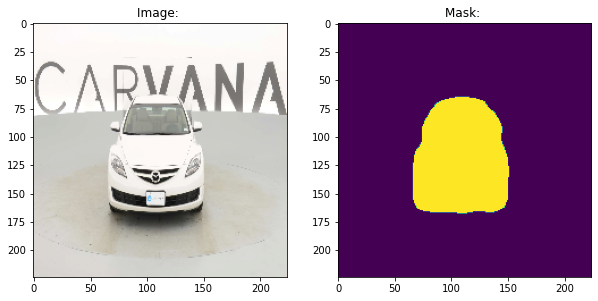

In [45]:
threshold = 0.5

image = utils.tensor_to_ndimage(batch["image"][0])

mask_ = tta_predictions["logits"][0, 0].sigmoid()
mask = utils.detach(mask_ > threshold).astype("float")

show_examples(name="", image=image, mask=mask)